# Deliverable 1

In [1]:
import torch

## **FCNN**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**DATA:**
- Train : Val | 0.8 : 0.2
- Batch size : 64

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

# Define transformations
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    # for the best performance, comment the following  lines for FCNN
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    # I did not use the following 2 lines for CNN
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    # ------------end of the lines----------------

    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409),
                         (0.2673, 0.2564, 0.2762))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409),
                         (0.2673, 0.2564, 0.2762))
])


# Load full training dataset
full_trainset = torchvision.datasets.CIFAR100(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

# Define split sizes (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(full_trainset))  # 80% for training
val_size = len(full_trainset) - train_size  # 20% for validation

# Randomly split into training and validation sets
trainset, valset = random_split(full_trainset, [train_size, val_size])

# Load the test set separately
testset = torchvision.datasets.CIFAR100(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

# Create DataLoaders
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = DataLoader(valset, batch_size=64, shuffle=False)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


_The mean and std of the data is from [link](https://github.com/weiaicunzai/pytorch-cifar100/blob/master/conf/global_settings.py#L15-L16)_

In [12]:
print(f"Dataset size: {len(trainset)}")  # 50000



# 获取一个样本
image, label = trainset[0]
print(f"Image shape: {image.shape}")  # torch.Size([3, 32, 32])
print(f"Image data type: {type(image)}")  # <class 'torch.Tensor'>

Dataset size: 40000
Image shape: torch.Size([3, 32, 32])
Image data type: <class 'torch.Tensor'>


**FCNN definition**

In [6]:
import torch
import torch.nn as nn

class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.input_dim = 3 * 32 * 32  # 3072
        
        self.fc1 = nn.Linear(self.input_dim, 1024)     # 隐藏层增加到 1024
        self.bn1 = nn.BatchNorm1d(1024)               # BatchNorm
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        
        self.fc5 = nn.Linear(128, 100)  # CIFAR-100 有 100 个类别
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
    
    def forward(self, x):
        x = x.view(-1, self.input_dim)  # Flatten
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc5(x)
        return x


In [18]:
print(model)

FCNN(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=128, out_features=100, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
)


**Training**

In [ ]:
import torch.optim as optim
import copy

model = FCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)



num_epochs = 50
patience = 3  
best_val_loss = float("inf")
epochs_no_improve = 0

train_losses = []
val_losses = []
val_accuracies = []

best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    # ====== 训练阶段 ======
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # ====== 验证阶段 ======
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    
    # 验证不用计算梯度
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)  

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_acc = 100.0 * correct / total
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val Acc: {epoch_val_acc:.2f}%")
    
    # ====== Early Stopping 检查 ======
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# 训练完成后，将模型权重设为在验证集上表现最好的那一次
model.load_state_dict(best_model_wts)
print("Training finished.")


Epoch [1/50] Train Loss: 4.1194, Val Loss: 3.7760, Val Acc: 11.87%
Epoch [2/50] Train Loss: 3.8434, Val Loss: 3.6197, Val Acc: 14.24%
Epoch [3/50] Train Loss: 3.7503, Val Loss: 3.5564, Val Acc: 15.84%
Epoch [4/50] Train Loss: 3.6696, Val Loss: 3.4856, Val Acc: 16.72%
Epoch [5/50] Train Loss: 3.6217, Val Loss: 3.4356, Val Acc: 18.10%
Epoch [6/50] Train Loss: 3.5782, Val Loss: 3.4041, Val Acc: 18.21%
Epoch [7/50] Train Loss: 3.5423, Val Loss: 3.3375, Val Acc: 20.24%
Epoch [8/50] Train Loss: 3.4992, Val Loss: 3.3135, Val Acc: 20.14%
Epoch [9/50] Train Loss: 3.4730, Val Loss: 3.2792, Val Acc: 20.37%
Epoch [10/50] Train Loss: 3.4396, Val Loss: 3.2770, Val Acc: 20.63%
Epoch [11/50] Train Loss: 3.4124, Val Loss: 3.2420, Val Acc: 21.51%
Epoch [12/50] Train Loss: 3.3838, Val Loss: 3.2251, Val Acc: 21.82%
Epoch [13/50] Train Loss: 3.3606, Val Loss: 3.2115, Val Acc: 21.66%
Epoch [14/50] Train Loss: 3.3379, Val Loss: 3.2013, Val Acc: 22.54%
Epoch [15/50] Train Loss: 3.3066, Val Loss: 3.1834, Val A

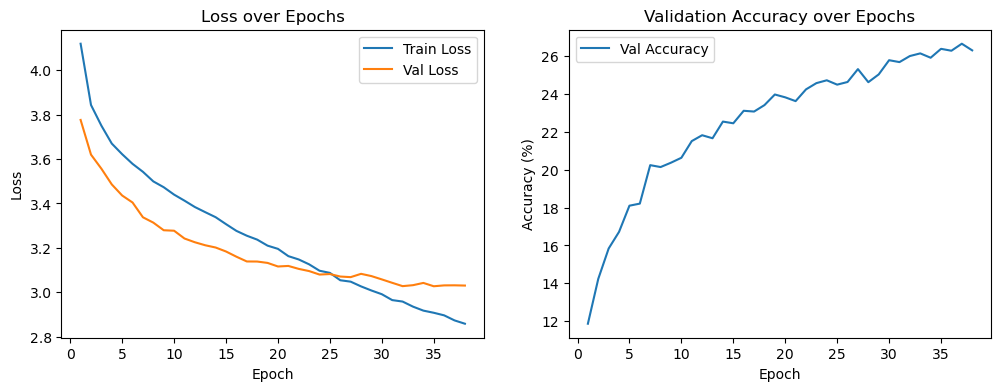

In [20]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,4))

# ========== Loss 可视化 ==========
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# ========== Accuracy 可视化 ==========
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()


In [21]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100.0 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 26.03%


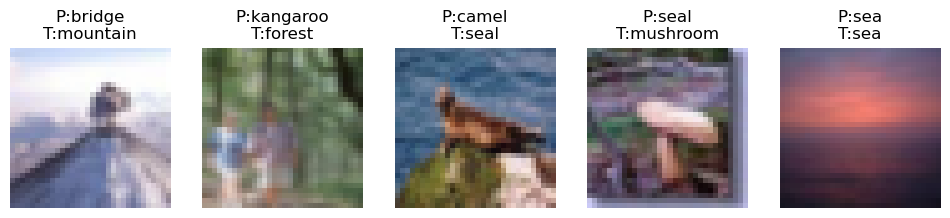

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = iter(test_loader)
images, labels = next(data_iter)

images_gpu = images.cuda()
outputs = model(images_gpu)
_, predicted = torch.max(outputs, 1)

N = 5  
class_names = testset.classes  

fig, axs = plt.subplots(1, N, figsize=(12, 3))
for i in range(N):
    img = images[i].permute(1, 2, 0).cpu().numpy()  # shape: 32×32×3

    mean = np.array([0.5071, 0.4865, 0.4409])
    std  = np.array([0.2673, 0.2564, 0.2762])
    img = std * img + mean
    img = np.clip(img, 0, 1)  

    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"P:{class_names[predicted[i].item()]}\nT:{class_names[labels[i].item()]}")

plt.show()


## **my CNN**

In [10]:
import torch.optim as optim
import copy
from mytorch import MyConv2D, MyMaxPool2D
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = MyConv2D(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.pool1 = MyMaxPool2D(kernel_size=2, stride=2)
        
        self.conv2 = MyConv2D(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.pool2 = MyMaxPool2D(kernel_size=2, stride=2)
        
        self.conv3 = MyConv2D(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.pool3 = MyMaxPool2D(kernel_size=2, stride=2)

        self.conv4 = MyConv2D(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4   = nn.BatchNorm2d(128)
        self.pool4 = MyMaxPool2D(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128*2*2, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256,128)
        self.bn6 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
        self.Dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # conv1 -> ReLU -> pool1
        x = self.conv1(x) 
        x = self.bn1(x) 
        x = self.relu(x)
        x = self.pool1(x)
        # conv1 -> ReLU -> pool1
        x = self.conv2(x) 
        x = self.bn2(x) 
        x = self.relu(x)
        x = self.pool2(x)
    
        x = self.conv3(x) 
        x = self.bn3(x) 
        x = self.relu(x)
        x = self.Dropout(x)
        x = self.pool3(x)

        x = self.conv4(x) 
        x = self.bn4(x) 
        x = self.relu(x)
        x = self.Dropout(x)
        x = self.pool4(x)
        
        x = x.view(x.size(0), -1)  
        # FC
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.Dropout(x)
        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu(x)
        x = self.Dropout(x)
        x = self.fc3(x)
        return x


In [16]:
def train_model(model, train_loader, val_loader, device, num_epochs=10, patience=3, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_val_loss = float("inf")
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0
    
    train_losses = []
    val_losses   = []
    val_accs     = []
    
    for epoch in range(num_epochs):
        # ======== 训练阶段 ========
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # ======== 验证阶段 ========
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = 100.0 * correct / total
        
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Acc: {epoch_val_acc:.2f}%")
        
        # Early Stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered!")
                break

    # 恢复验证集上最优的权重
    model.load_state_dict(best_model_wts)
    
    # 可视化训练过程
    epochs_range = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs_range, val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy")
    plt.legend()
    
    plt.show()
    
    return model


In [8]:
def evaluate_and_visualize(model, test_loader, device, num_images=5):
    model.eval()
    
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())
    
    test_acc = 100.0 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

    # =========== 可视化部分 ==========
    
    # CIFAR-100 的标签
    class_names = test_loader.dataset.classes
    
    # 随机选一批
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # 显示前num_images张
    plt.figure(figsize=(12,4))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img = images[i].cpu().permute(1,2,0).numpy()
        
        # 如果有 Normalize，需要反归一化
        mean = np.array([0.5071, 0.4865, 0.4409])
        std  = np.array([0.2673, 0.2564, 0.2762])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(f"Pred: {class_names[predicted[i].item()]}\nTrue: {class_names[labels[i].item()]}")
        plt.axis("off")
    
    plt.show()


Using device: cuda
Epoch [1/50] Train Loss: 4.0679, Val Loss: 3.9816, Val Acc: 9.12%
Epoch [2/50] Train Loss: 3.6078, Val Loss: 3.6340, Val Acc: 14.50%
Epoch [3/50] Train Loss: 3.3302, Val Loss: 3.3471, Val Acc: 18.80%
Epoch [4/50] Train Loss: 3.1324, Val Loss: 3.1590, Val Acc: 22.72%
Epoch [5/50] Train Loss: 2.9872, Val Loss: 2.9747, Val Acc: 26.15%
Epoch [6/50] Train Loss: 2.8904, Val Loss: 2.9700, Val Acc: 25.63%
Epoch [7/50] Train Loss: 2.8066, Val Loss: 2.8250, Val Acc: 29.75%
Epoch [8/50] Train Loss: 2.7524, Val Loss: 2.7857, Val Acc: 30.48%
Epoch [9/50] Train Loss: 2.7009, Val Loss: 2.7692, Val Acc: 30.19%
Epoch [10/50] Train Loss: 2.6481, Val Loss: 2.6428, Val Acc: 34.24%
Epoch [11/50] Train Loss: 2.6022, Val Loss: 2.6016, Val Acc: 34.56%
Epoch [12/50] Train Loss: 2.5660, Val Loss: 2.6253, Val Acc: 33.57%
Epoch [13/50] Train Loss: 2.5405, Val Loss: 2.5394, Val Acc: 36.41%
Epoch [14/50] Train Loss: 2.5108, Val Loss: 2.5284, Val Acc: 36.02%
Epoch [15/50] Train Loss: 2.4775, Val L

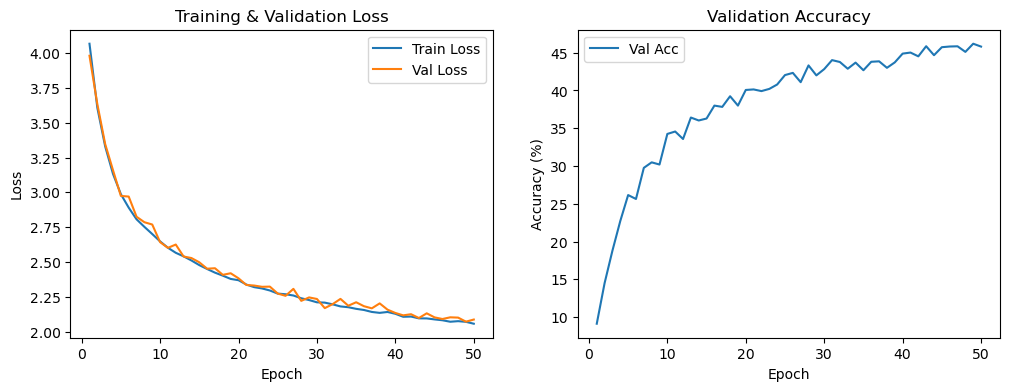

Test Accuracy: 47.79%


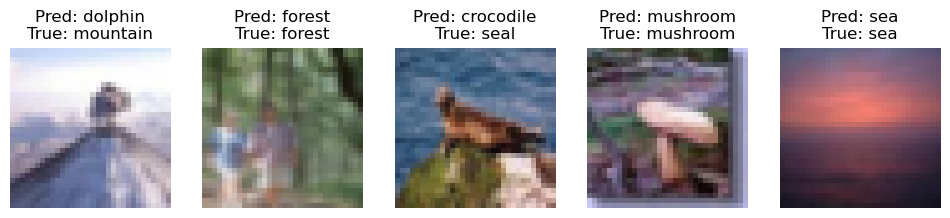

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_CNN = SimpleCNN(num_classes=100).to(device)

# 4) 训练
model_CNN = train_model(
    model_CNN, 
    train_loader, 
    val_loader, 
    device=device, 
    num_epochs=50, 
    patience=10, 
    lr=0.001
)

evaluate_and_visualize(model_CNN, test_loader, device, num_images=5)


Updating lr and num of epochs

Using device: cuda
Epoch [1/100] Train Loss: 3.9872, Val Loss: 3.9025, Val Acc: 9.95%
Epoch [2/100] Train Loss: 3.5795, Val Loss: 3.7315, Val Acc: 11.63%
Epoch [3/100] Train Loss: 3.3303, Val Loss: 3.3346, Val Acc: 19.01%
Epoch [4/100] Train Loss: 3.1570, Val Loss: 3.1650, Val Acc: 22.38%
Epoch [5/100] Train Loss: 3.0148, Val Loss: 2.9639, Val Acc: 26.73%
Epoch [6/100] Train Loss: 2.9068, Val Loss: 2.9324, Val Acc: 27.67%
Epoch [7/100] Train Loss: 2.8309, Val Loss: 2.8858, Val Acc: 28.19%
Epoch [8/100] Train Loss: 2.7665, Val Loss: 2.8160, Val Acc: 30.14%
Epoch [9/100] Train Loss: 2.7055, Val Loss: 2.7466, Val Acc: 31.07%
Epoch [10/100] Train Loss: 2.6662, Val Loss: 2.7114, Val Acc: 32.40%
Epoch [11/100] Train Loss: 2.6206, Val Loss: 2.5904, Val Acc: 35.65%
Epoch [12/100] Train Loss: 2.5921, Val Loss: 2.5714, Val Acc: 35.62%
Epoch [13/100] Train Loss: 2.5468, Val Loss: 2.5636, Val Acc: 35.35%
Epoch [14/100] Train Loss: 2.5175, Val Loss: 2.6200, Val Acc: 33.55%
Epoch [15/100] Train Loss

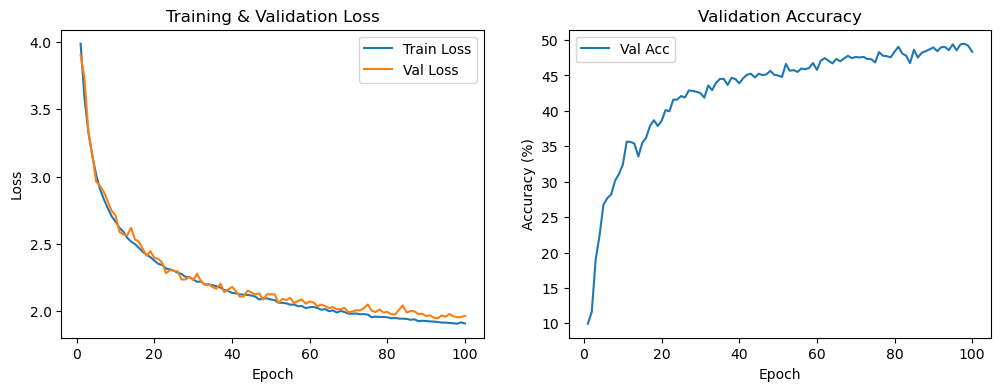

Test Accuracy: 49.72%


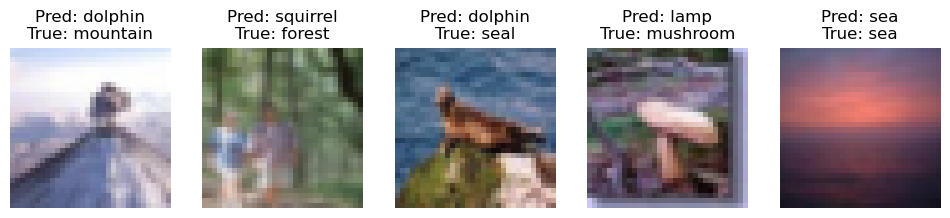

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_CNN = SimpleCNN(num_classes=100).to(device)

# 4) 训练
model_CNN = train_model(
    model_CNN, 
    train_loader, 
    val_loader, 
    device=device, 
    num_epochs=100, 
    patience=10, 
    lr=0.002
)

evaluate_and_visualize(model_CNN, test_loader, device, num_images=5)

# Deliverable 2
## **Mini-Resnet**

**New training function(added cosine annealing and used SGD)**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy

def train_model(model, train_loader, val_loader, device,
                num_epochs=50, lr=0.01, t_max=50):
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    # Cosine Annealing
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max)
    
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    
    train_losses = []
    val_losses   = []
    val_accs     = []
    
    for epoch in range(num_epochs):
        # ====== Training ======
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # ====== Validation ======
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = 100.0 * correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        scheduler.step()
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Acc: {epoch_val_acc:.2f}% , "
              f"LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # 恢复最优权重
    model.load_state_dict(best_model_wts)
    
    # visualize
    plt.figure(figsize=(12,4))
    epochs_range = range(1, num_epochs+1)
    
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs_range, val_accs, label='Val Acc')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy %")
    plt.legend()
    
    plt.show()
    
    return model


In [32]:
def evaluate_and_visualize_n(model, test_loader, device, num_images=5,num_row = 1,num_col = 5):
    model.eval()
    
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())
    
    test_acc = 100.0 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

    # =========== 可视化部分 ==========
    
    # CIFAR-100 的标签
    class_names = test_loader.dataset.classes
    
    # 随机选一批
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # 显示前num_images张
    plt.figure(figsize=(12,10))
    for i in range(num_images):
        plt.subplot(num_row,num_col, i+1)
        img = images[i].cpu().permute(1,2,0).numpy()
        
        # 如果有 Normalize，需要反归一化
        mean = np.array([0.5071, 0.4865, 0.4409])
        std  = np.array([0.2673, 0.2564, 0.2762])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(f"Pred: {class_names[predicted[i].item()]}\nTrue: {class_names[labels[i].item()]}")
        plt.axis("off")
    
    plt.show()


**Basic Residual Block**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1  
    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        
        self.downsample = downsample  

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)  # if stride != 1 or in != out downsample
            
        out += identity
        out = F.relu(out)
        return out


**ResNet Constuct**

In [35]:
class MiniResNet(nn.Module):
    def __init__(self, block=BasicBlock, num_blocks=(1,1,1,1), num_classes=100): # block is BasicBlock
        super(MiniResNet, self).__init__()
        # conv1
        self.in_planes = 32  # initial in_planes
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(self.in_planes)
        
        # 32 -> 64 -> 128 -> 256
        self.layer1 = self._make_layer(block, 32,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64,  num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        
        self.linear = nn.Linear(256 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_planes, num_block, stride):
        # Build several BasicBlocks to form a Stage 
        layers = []
        
        # the first block needs downsampling
        downsample = None
        if stride != 1 or self.in_planes != out_planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, out_planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )
        
        layers.append(block(self.in_planes, out_planes, stride, downsample))
        self.in_planes = out_planes  # 更新 in_planes
        
        # The following blocks don't need downsampling
        for _ in range(1, num_block):
            layers.append(block(out_planes, out_planes))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = nn.Dropout(0.2)(out) # I didn't use dropout in the first mini resnet
        out = self.layer3(out)
        out = self.layer4(out)
        
        # Global Average Pool, H×W -> 1×1
        out = F.adaptive_avg_pool2d(out, (1,1))
        out = out.view(out.size(0), -1)  # [B, 256]
        # out = nn.Dropout(0.2)(out) # I didn't use dropout in the first mini resnet
        out = self.linear(out)
        return out


Using device: cuda
Epoch [1/50], Train Loss: 3.8503, Val Loss: 3.4766, Val Acc: 15.57% , LR: 0.009990
Epoch [2/50], Train Loss: 3.2327, Val Loss: 3.0502, Val Acc: 24.09% , LR: 0.009961
Epoch [3/50], Train Loss: 2.8797, Val Loss: 2.9061, Val Acc: 26.70% , LR: 0.009911
Epoch [4/50], Train Loss: 2.6232, Val Loss: 2.6707, Val Acc: 31.60% , LR: 0.009843
Epoch [5/50], Train Loss: 2.4135, Val Loss: 2.4572, Val Acc: 36.13% , LR: 0.009755
Epoch [6/50], Train Loss: 2.2474, Val Loss: 2.3367, Val Acc: 38.55% , LR: 0.009649
Epoch [7/50], Train Loss: 2.1093, Val Loss: 2.1930, Val Acc: 41.76% , LR: 0.009524
Epoch [8/50], Train Loss: 1.9804, Val Loss: 2.1578, Val Acc: 42.13% , LR: 0.009382
Epoch [9/50], Train Loss: 1.8838, Val Loss: 2.0015, Val Acc: 45.81% , LR: 0.009222
Epoch [10/50], Train Loss: 1.7911, Val Loss: 1.9259, Val Acc: 47.92% , LR: 0.009045
Epoch [11/50], Train Loss: 1.7191, Val Loss: 1.9108, Val Acc: 48.11% , LR: 0.008853
Epoch [12/50], Train Loss: 1.6413, Val Loss: 1.8068, Val Acc: 50.7

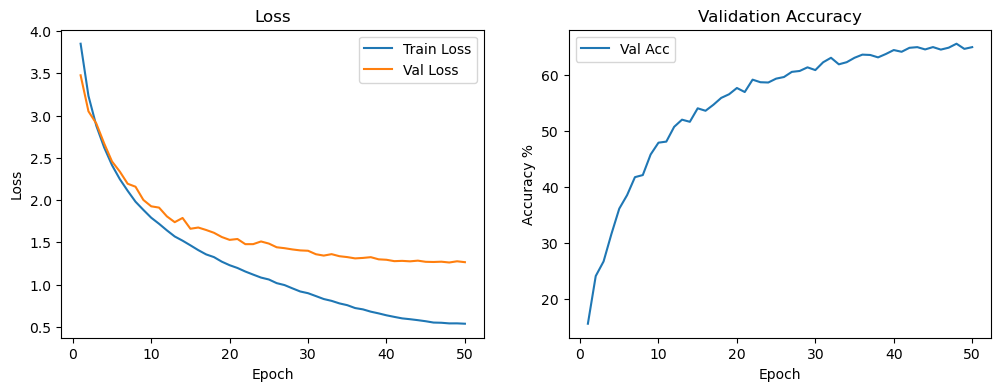

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MiniResNet(block=BasicBlock, num_blocks=(1,1,1,1), num_classes=100)

model = train_model(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=50,
    lr=0.01,        
    t_max=50     
)


Test Accuracy: 65.89%


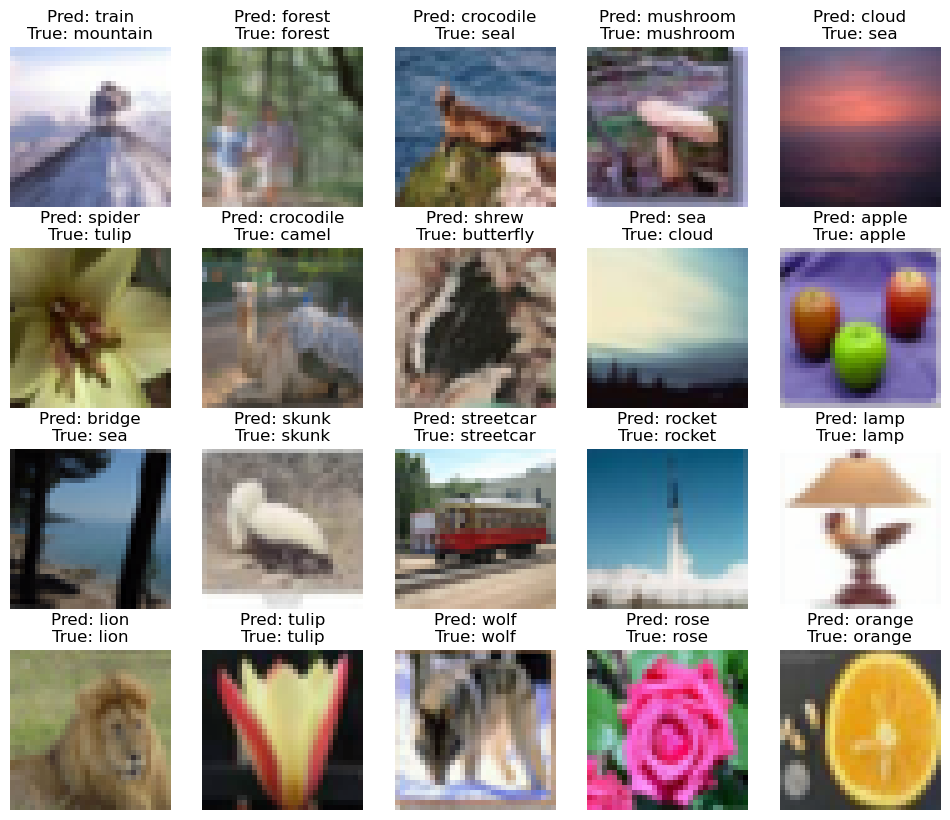

In [37]:
evaluate_and_visualize_n(model, test_loader, device, num_images=20, num_row = 4, num_col = 5)

Using device: cuda
Epoch [1/50], Train Loss: 3.9058, Val Loss: 3.6021, Val Acc: 14.64% , LR: 0.009990
Epoch [2/50], Train Loss: 3.3198, Val Loss: 3.1851, Val Acc: 21.46% , LR: 0.009961
Epoch [3/50], Train Loss: 2.8933, Val Loss: 2.7905, Val Acc: 28.27% , LR: 0.009911
Epoch [4/50], Train Loss: 2.5624, Val Loss: 2.4927, Val Acc: 34.36% , LR: 0.009843
Epoch [5/50], Train Loss: 2.3267, Val Loss: 2.3687, Val Acc: 37.81% , LR: 0.009755
Epoch [6/50], Train Loss: 2.1453, Val Loss: 2.1554, Val Acc: 42.30% , LR: 0.009649
Epoch [7/50], Train Loss: 2.0037, Val Loss: 2.2238, Val Acc: 41.62% , LR: 0.009524
Epoch [8/50], Train Loss: 1.8702, Val Loss: 2.1852, Val Acc: 41.80% , LR: 0.009382
Epoch [9/50], Train Loss: 1.7683, Val Loss: 2.1510, Val Acc: 43.30% , LR: 0.009222
Epoch [10/50], Train Loss: 1.6805, Val Loss: 1.8667, Val Acc: 48.34% , LR: 0.009045
Epoch [11/50], Train Loss: 1.5945, Val Loss: 1.7968, Val Acc: 50.78% , LR: 0.008853
Epoch [12/50], Train Loss: 1.5239, Val Loss: 1.8260, Val Acc: 50.2

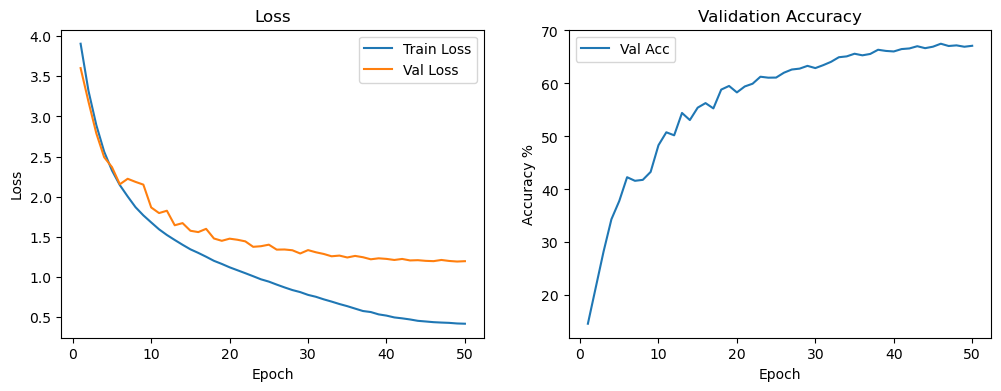

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_mini_res_2 = MiniResNet(block=BasicBlock, num_blocks=(2,2,1,1), num_classes=100)

model_mini_res_2 = train_model(
    model_mini_res_2,
    train_loader,
    val_loader,
    device,
    num_epochs=50,
    lr=0.01,      
    t_max=50       
)


Test Accuracy: 67.27%


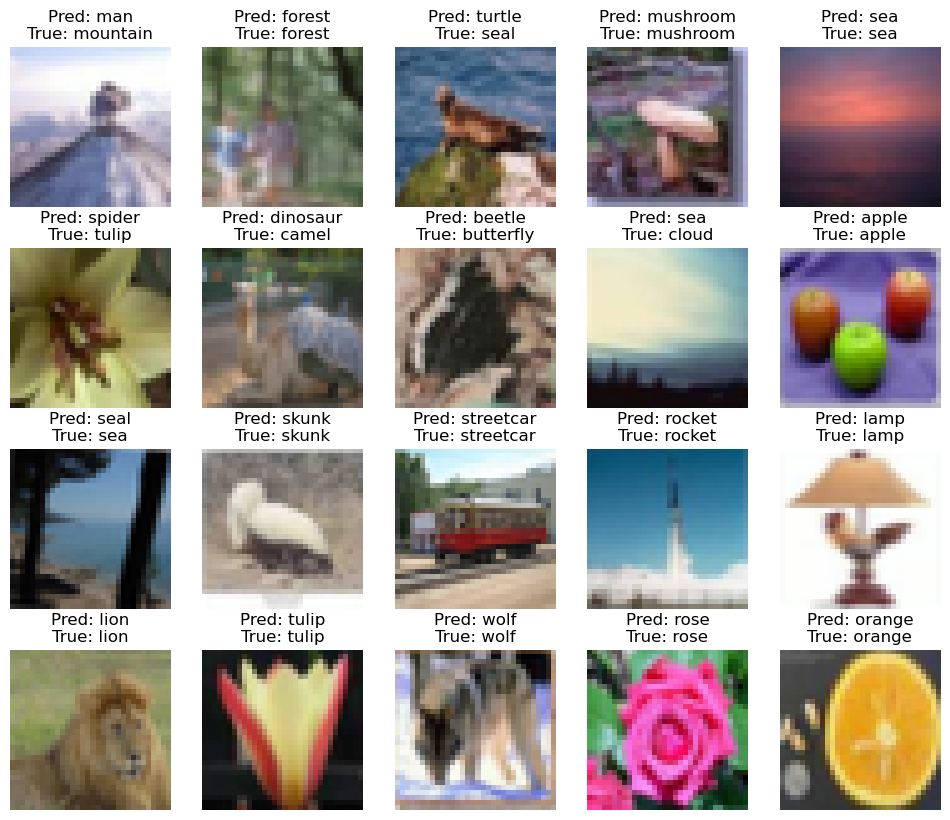

In [39]:
evaluate_and_visualize_n(model_mini_res_2, test_loader, device, num_images=20, num_row = 4, num_col = 5)